# calculate the leadtime-dependent climatological terciles, deciles and percentiles (0.02, then 0.05 to 0.95 with 0.05 step) from the individual GCMs' hindcast dataset (period 1993 - 2016) 

#### **Note**: this is quite slow: It takes about 15 minutes to process a complete climatology (12 months) for one GCM, for one accumulation period (monthly or seasonal), but only needs to be calculated once ... 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os
import os
import sys
from collections import OrderedDict

### datetimes
from datetime import datetime, timedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns


In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [4]:
sys.path.append('../../') 

In [5]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

### dictionnary holding quantile name and quantile values, they are passed as **lists** to avoid any numerical issues 

In [6]:
dict_quantiles = OrderedDict()
dict_quantiles['tercile'] = [0.3333, 0.6666]
dict_quantiles['decile'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dict_quantiles['percentile'] = [0.02, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95] 

### variables 

### provider 

In [7]:
provider = 'CDS'

### variable name in the hindcast dataset 

In [8]:
varname = 'tprate'

### period: `monthly` or `seasonal` 

In [9]:
period = 'monthly'
# period = 'seasonal'

### list of valid GCMs 

In [10]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP']

### demonstration for one GCM, this code will e.g. need to be re-run every month for the ECC, as the hindcast dataset is apparently updated once the corresponding forecasts are made available 

In [11]:
GCM = 'ECMWF'

### path definitions follow

#### where to find the GCM hindcast datasets 

In [12]:
gcm_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}')

In [13]:
dpath = gcm_path.joinpath(GCM).joinpath(varname.upper())

In [14]:
print(dpath)

/media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE


#### where to save the climatologies 

In [15]:
clim_path = gcm_path.joinpath(f'CLIMATOLOGY/{GCM}')

In [16]:
clim_path

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/CLIMATOLOGY/ECMWF')

In [17]:
if not clim_path.exists(): 
    
    clim_path.mkdir(parents=True)

### get the list of files 

In [18]:
lfiles = list(dpath.glob(f"ensemble_seas_forecasts_{varname}_from_*_{GCM}.netcdf"))

In [19]:
lfiles.sort()

In [20]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE/ensemble_seas_forecasts_tprate_from_1993_01_ECMWF.netcdf')

In [21]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE/ensemble_seas_forecasts_tprate_from_2021_04_ECMWF.netcdf')

In [22]:
len(lfiles)

338

### open the multiple files dataset, concatenating over the time dimension, and preprocessing 

In [23]:
dset = xr.open_mfdataset(lfiles, preprocess=C3S.preprocess_GCM, parallel=True, engine='netcdf4')

In [24]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (member: 51, time: 338, lon: 126, lat: 86, step: 5)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2021-04-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 242.0 243.0 244.0 245.0
  * lat      (lat) float32 -55.0 -54.0 -53.0 -52.0 -51.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 1 2 3 4 5
Data variables:
    tprate   (time, step, member, lat, lon) float32 dask.array<chunksize=(1, 5, 51, 86, 126), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 19:56:10 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

### print the number of members in the ensemble for each time step 

In [46]:
# for t in range(len(dset.time)): 
    
#     s = dset.isel(time=t)
    
#     print(f"{pd.to_datetime(dset.isel(time=t)['time'].data):%Y-%m}:", len(s.dropna('member')['member']))

### selects the hindcast period 

In [26]:
dset = dset.sel(time=slice('1993', '2016'))

In [27]:
dset

,Array,Chunk
Bytes,2.96 GiB,10.54 MiB
Shape,"(288, 5, 51, 86, 126)","(1, 5, 51, 86, 126)"
Count,2955 Tasks,288 Chunks
Type,float32,numpy.ndarray


### convert to monthly rainfall accumulations (mm/month)

In [28]:
dset.tprate.attrs

{'units': 'm s**-1', 'long_name': 'Mean total precipitation rate'}

In [29]:
dset = C3S.convert_rainfall(dset, varin='tprate', varout='precip', leadvar='step', timevar='time', dropvar=True)


unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip


In [30]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (member: 51, time: 288, lon: 126, lat: 86, step: 5)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 242.0 243.0 244.0 245.0
  * lat      (lat) float32 -55.0 -54.0 -53.0 -52.0 -51.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 1 2 3 4 5
Data variables:
    precip   (time, step, member, lat, lon) float64 dask.array<chunksize=(1, 5, 51, 86, 126), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 19:56:10 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

In [31]:
dset.precip.attrs

{'units': 'mm/month'}

### make sure there are no negative values 

In [32]:
dset = dset.clip(min=0)

### if the period is set to `seasonal`, calculates the seasonal accumulations 

In [33]:
if period == 'seasonal': 
    
    dset = dset.rolling({'step':3}, min_periods=3).sum('step')
    
    dset = dset.sel({'step':slice(3, None)})

In [34]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (time: 288, step: 5, member: 51, lat: 86, lon: 126)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 242.0 243.0 244.0 245.0
  * lat      (lat) float32 -55.0 -54.0 -53.0 -52.0 -51.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 1 2 3 4 5
Data variables:
    precip   (time, step, member, lat, lon) float64 dask.array<chunksize=(1, 5, 51, 86, 126), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 19:56:10 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

### calculate percentiles over the dimensions member and time, will then be lead time dependent 

In [35]:
def calc_percentiles(dset, percentiles=None, dims=['member','time']):
    """
    calculates the climatological percentiles, over dimensions 
    ['member','time'] from a CDS hindcast dataset 
    
    Arguments
    ---------
    
    Returns
    -------
    """
    if percentiles is None: 
        
        percentiles = np.insert(np.arange(0.05, 1., 0.05), 0, 0.02)
        
    return dset.quantile(percentiles, dim=dims) 

In [36]:
coastlines_dpath = '/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles'


In [37]:
shapefile = geo.get_coastlines(dpath_shapes=coastlines_dpath)

In [38]:
shapefile.head(3)

,country_na,OBJECTID,COUNTRY_ID,ICU,Stress,SOPAC,FFA,SPC,SPREP,USP,TCSP,FORUM,ACP,area,Shape_Leng,Shape_Area,geometry
0,American Samoa,29.0,AS,4.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.054887e+09,1.778971,0.017481,"MULTIPOLYGON (((191.856 -14.549, 191.855 -14.5..."
1,Cook Islands,8.0,CK,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.977260,0.002987,"MULTIPOLYGON (((202.122 -21.955, 202.121 -21.9..."
2,Federated States of Micronesia,10.0,FM,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,11.676262,0.063027,"MULTIPOLYGON (((154.781 1.026, 154.780 1.025, ..."


In [39]:
shapefile.columns

Index(['country_na', 'OBJECTID', 'COUNTRY_ID', 'ICU', 'Stress', 'SOPAC', 'FFA',
       'SPC', 'SPREP', 'USP', 'TCSP', 'FORUM', 'ACP', 'area', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')

In [40]:
shapefile.country_na.values

array(['American Samoa', 'Cook Islands', 'Federated States of Micronesia',
       'Fiji', 'French Polynesia', 'Guam', 'Kiribati: Gilbert Islands',
       'Kiribati: Line Islands', 'Kiribati: Phoenix Islands',
       'Marshall Islands', 'Nauru', 'New Caledonia', 'Niue',
       'Northern Marianas', 'Palau', 'Papua New Guinea',
       'Pitcairn Islands', 'Samoa', 'Solomon Islands', 'Tokelau', 'Tonga',
       'Tuvalu', 'Vanuatu', 'Wallis & Futuna'], dtype=object)

In [41]:
location_col = 'country_na'

In [42]:
shape_name = 'Fiji'

In [43]:
shape = shapefile.query(f"{location_col} == '{shape_name}'")

In [44]:
shape

,country_na,OBJECTID,COUNTRY_ID,ICU,Stress,SOPAC,FFA,SPC,SPREP,USP,TCSP,FORUM,ACP,area,Shape_Leng,Shape_Area,geometry
3,Fiji,6.0,FJ,2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.655862,1.611568,"MULTIPOLYGON (((181.155 -21.042, 181.154 -21.0..."


<AxesSubplot:>

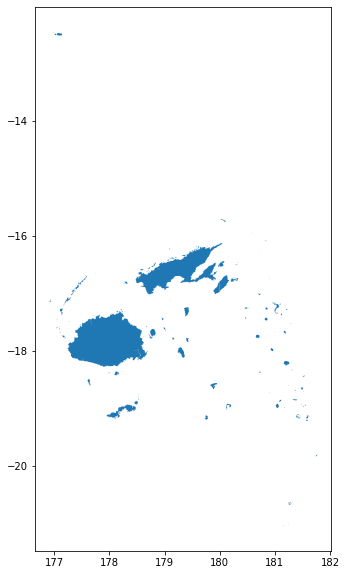

In [45]:
shape.plot(figsize=(10,10))

In [47]:
new_shape = geo.filter_by_area(shape)

TypeError: '>' not supported between instances of 'Polygon' and 'float'

In [62]:
new_shape

,geometry
0,"MULTIPOLYGON (((178.331 -18.933, 178.333 -18.9..."


In [63]:
dset, domain = mask_dataset(dset, new_shape, coastline_buffer=5)

[########################################] | 100% Completed |  5.8s


In [64]:
dset['mask'].attrs['cells']

83

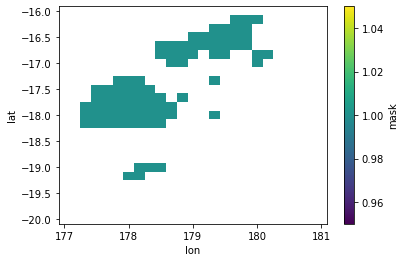

In [65]:
dset['mask'].plot()

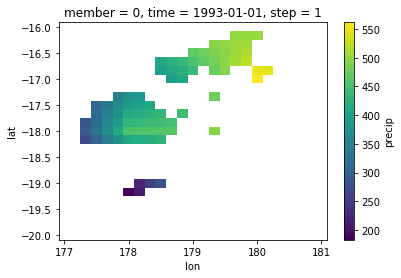

In [66]:
dset.isel(time=0, step=0, member=0)['precip'].plot()

### calculates the regional average 

In [67]:
dset_sub = dset.mean(['lat','lon'])

### and the calculates the climatological percentiles 

#### terciles 

In [68]:
percentiles = [0.3333, 0.6666]

In [69]:
clim_p = dset_sub[['precip']].groupby(dset_sub.time.dt.month).apply(calc_percentiles, **{'percentiles':percentiles})

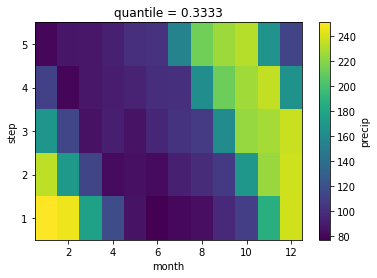

In [70]:
clim_p.sel(quantile=0.3333)['precip'].plot(x='month', y = 'step')

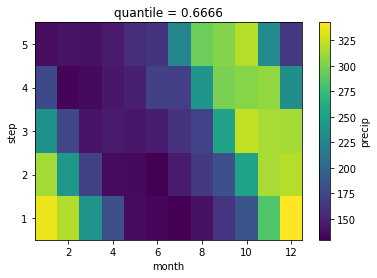

In [71]:
clim_p.sel(quantile=0.6666)['precip'].plot(x='month', y = 'step')

In [72]:
dset_sub

<xarray.Dataset>
Dimensions:  (time: 288, step: 5, member: 51)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
Data variables:
    precip   (time, step, member) float64 416.2 211.8 238.5 ... nan nan nan
    mask     float64 1.0

In [73]:
clim_p

<xarray.Dataset>
Dimensions:   (month: 12, quantile: 2, step: 5)
Coordinates:
  * step      (step) int64 1 2 3 4 5
  * quantile  (quantile) float64 0.3333 0.6666
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip    (month, quantile, step) float64 250.7 233.3 168.4 ... 233.8 164.4

In [127]:
dset_cat = []

for month in np.arange(12) + 1: 
    
    x = dset_sub.sel(time=(dset_sub.time.dt.month == month))
    
    # drop the missing members 
    
    x = x.dropna('member')
    
    # digitize

    qc = C3S.get_GCM_category_digitize(x, clim_p.sel(month=month), varname='precip', dim='quantile')
    
    dset_cat.append(qc)

In [75]:
dset_cat = xr.concat(dset_cat, dim='time')

In [76]:
dset_cat = dset_cat.sortby('time')

In [77]:
dset_cat

<xarray.Dataset>
Dimensions:  (member: 25, time: 288, step: 5)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, step, member) int64 3 1 1 2 1 1 1 1 2 ... 3 3 1 2 2 1 1 2 2

In [78]:
terciles_category_percent = C3S.calculate_quantiles_probabilities(dset_cat, ncategories=3)

In [79]:
terciles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 288, step: 5)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step) float64 56.0 40.0 56.0 ... 36.0 32.0 20.0

### because of numerical approximations, sometimes the sum over the quantile dimension is not strictly equal to 100.

In [80]:
np.alltrue((terciles_category_percent.sum('tercile')['precip'] == 100.))

<xarray.DataArray 'precip' ()>
array(False)

In [81]:
np.alltrue((terciles_category_percent.sum('tercile')['precip'] >= 99.9999))

<xarray.DataArray 'precip' ()>
array(True)

In [82]:
np.alltrue((terciles_category_percent.sum('tercile')['precip'] <= 100.0001))

<xarray.DataArray 'precip' ()>
array(True)

In [83]:
terciles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 288, step: 5)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step) float64 56.0 40.0 56.0 ... 36.0 32.0 20.0

In [84]:
lead = 1

In [85]:
terciles_category_percent_df = terciles_category_percent.sel(step=lead)['precip'].to_pandas().T

In [86]:
terciles_category_percent_df.head()

tercile,1,2,3
time,,,
1993-01-01,56.0,24.0,20.0
1993-02-01,44.0,44.0,12.0
1993-03-01,48.0,32.0,20.0
1993-04-01,72.0,16.0,12.0
1993-05-01,44.0,28.0,28.0


In [87]:
terciles_category_percent_df.head()

tercile,1,2,3
time,,,
1993-01-01,56.0,24.0,20.0
1993-02-01,44.0,44.0,12.0
1993-03-01,48.0,32.0,20.0
1993-04-01,72.0,16.0,12.0
1993-05-01,44.0,28.0,28.0


In [88]:
terciles_category_percent_df.index = terciles_category_percent_df.index + pd.offsets.MonthBegin(lead)

In [89]:
terciles_category_percent_df.head()

tercile,1,2,3
time,,,
1993-02-01,56.0,24.0,20.0
1993-03-01,44.0,44.0,12.0
1993-04-01,48.0,32.0,20.0
1993-05-01,72.0,16.0,12.0
1993-06-01,44.0,28.0,28.0


In [90]:
terciles_category_percent_df.sum(1)

time
1993-02-01    100.0
1993-03-01    100.0
1993-04-01    100.0
1993-05-01    100.0
1993-06-01    100.0
              ...  
2016-09-01    100.0
2016-10-01    100.0
2016-11-01    100.0
2016-12-01    100.0
2017-01-01    100.0
Length: 288, dtype: float64

In [91]:
terciles_category_percent_df.head()

tercile,1,2,3
time,,,
1993-02-01,56.0,24.0,20.0
1993-03-01,44.0,44.0,12.0
1993-04-01,48.0,32.0,20.0
1993-05-01,72.0,16.0,12.0
1993-06-01,44.0,28.0,28.0


In [92]:
most_likely_category_df = terciles_category_percent_df.idxmax(axis=1)

In [93]:
most_likely_category_df.head()

time
1993-02-01    1
1993-03-01    1
1993-04-01    1
1993-05-01    1
1993-06-01    1
dtype: int64

### approximately equiprobable categories over the 1993 - 2016 period 

In [94]:
most_likely_category_df.value_counts() / most_likely_category_df.value_counts().sum()

1    0.357639
3    0.343750
2    0.298611
dtype: float64

### Now we are going to read the ERA5 reanalysis precipitation data 

In [95]:
from ICU_Water_Watch import verification

In [96]:
use_verif = 'era'

In [97]:
dset_obs, dset_anomalies = verification.get_era5()

In [98]:
dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

### insert a dummy "member" dimension with one coordinate

In [99]:
dset_obs = dset_obs.expand_dims({'member':[1]})

In [100]:
dset_obs

,Array,Chunk
Bytes,28.12 kiB,100 B
Shape,"(1, 288, 5, 5)","(1, 1, 5, 5)"
Count,3464 Tasks,288 Chunks
Type,float32,numpy.ndarray


In [101]:
dset_obs, domain = mask_dataset(dset_obs, shape, coastline_buffer=5)

[########################################] | 100% Completed |  3.3s


In [102]:
dset_obs

<xarray.Dataset>
Dimensions:  (member: 1, time: 288, lat: 25, lon: 25)
Coordinates:
  * member   (member) int64 1
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float64 177.0 177.2 177.3 177.5 ... 180.5 180.7 180.8 181.0
  * lat      (lat) float64 -20.0 -19.83 -19.67 -19.5 ... -16.33 -16.17 -16.0
Data variables:
    precip   (member, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

### same grid and same mask as the GCM 

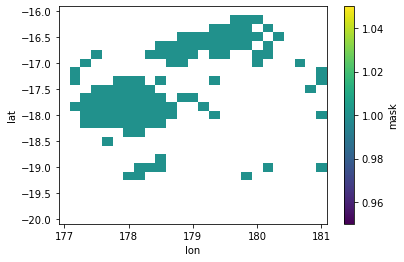

In [103]:
dset_obs['mask'].plot()

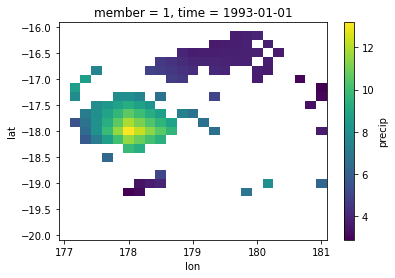

In [104]:
dset_obs.isel(time=0).squeeze()['precip'].plot()

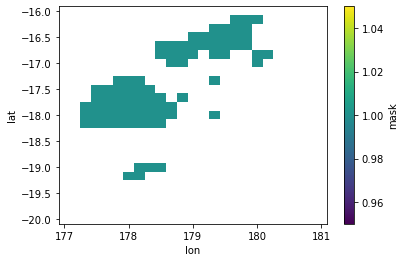

In [105]:
dset['mask'].plot()

### calculates the regional average 

In [106]:
dset_obs

<xarray.Dataset>
Dimensions:  (member: 1, time: 288, lat: 25, lon: 25)
Coordinates:
  * member   (member) int64 1
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float64 177.0 177.2 177.3 177.5 ... 180.5 180.7 180.8 181.0
  * lat      (lat) float64 -20.0 -19.83 -19.67 -19.5 ... -16.33 -16.17 -16.0
Data variables:
    precip   (member, time, lat, lon) float64 nan nan nan nan ... nan nan nan
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [107]:
dset_obs_sub = dset_obs[['precip']].mean(['lat','lon'])

In [108]:
dset_obs_sub

<xarray.Dataset>
Dimensions:  (member: 1, time: 288)
Coordinates:
  * member   (member) int64 1
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Data variables:
    precip   (member, time) float64 6.521 7.579 7.952 ... 6.741 3.541 15.75

In [109]:
percentiles = [0.3333, 0.6666]

In [119]:
# import seaborn as sns

In [ ]:
f, ax = plt.subplots()

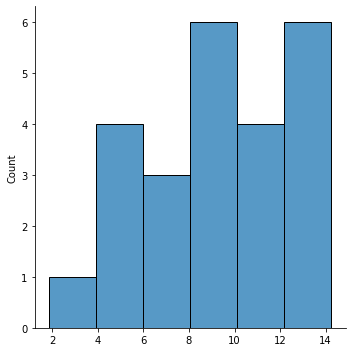

In [126]:
sns.displot(dset_obs_sub.sel(time=dset_sub.time.dt.month == 2)['precip'].data.flatten())

In [110]:
clim_obs_p = dset_obs_sub[['precip']].groupby(dset_obs_sub.time.dt.month).apply(calc_percentiles, **{'percentiles':percentiles})

In [125]:
clim_obs_p.sel(month=1)

<xarray.Dataset>
Dimensions:   (quantile: 2)
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6666
    month     int64 1
Data variables:
    precip    (quantile) float64 7.271 9.808

### Now calculates the categories, based on the observations

In [112]:
dset_obs_cat = []

for month in np.arange(12) + 1: 
    
    x = dset_obs_sub.sel(time=(dset_obs_sub.time.dt.month == month))

    # digitize

    qc = C3S.get_GCM_category_digitize(x, clim_obs_p.sel(month=month), varname='precip', dim='quantile')
    
    dset_obs_cat.append(qc)

In [113]:
dset_obs_cat = xr.concat(dset_obs_cat, dim='time')

In [114]:
dset_obs_cat = dset_obs_cat.sortby('time')

In [115]:
dset_obs_cat = dset_obs_cat.squeeze()['precip'].to_pandas()

In [116]:
df = pd.concat([most_likely_category_df.to_frame(name='forecast'), dset_obs_cat.to_frame(name='obs')], axis=1).dropna()

In [117]:
(df.forecast == df.obs).sum() / len(df)

0.43205574912891986